# Mask R-CNN demo

This notebook illustrates one possible way of using `maskrcnn_benchmark` for computing predictions on images from an arbitrary URL.

Let's start with a few standard imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

In [2]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [3]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [12]:
config_file = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda:0"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [13]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

In [14]:
cfg

CfgNode({'MODEL': CfgNode({'RPN_ONLY': False, 'MASK_ON': True, 'DEVICE': 'cuda:0', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHT': 'catalog://Caffe2Detectron/COCO/35858933/e2e_mask_rcnn_R-50-FPN_1x', 'BACKBONE': CfgNode({'CONV_BODY': 'R-50-FPN', 'FREEZE_CONV_BODY_AT': 2, 'OUT_CHANNELS': 256}), 'RPN': CfgNode({'USE_FPN': True, 'ANCHOR_SIZES': (32, 64, 128, 256, 512), 'ANCHOR_STRIDE': (4, 8, 16, 32, 64), 'ASPECT_RATIOS': (0.5, 1.0, 2.0), 'STRADDLE_THRESH': 0, 'FG_IOU_THRESHOLD': 0.7, 'BG_IOU_THRESHOLD': 0.3, 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'PRE_NMS_TOP_N_TRAIN': 2000, 'PRE_NMS_TOP_N_TEST': 1000, 'POST_NMS_TOP_N_TRAIN': 2000, 'POST_NMS_TOP_N_TEST': 1000, 'NMS_THRESH': 0.7, 'MIN_SIZE': 0, 'FPN_POST_NMS_TOP_N_TRAIN': 2000, 'FPN_POST_NMS_TOP_N_TEST': 1000, 'RPN_HEAD': 'SingleConvRPNHead'}), 'ROI_HEADS': CfgNode({'USE_FPN': True, 'FG_IOU_THRESHOLD': 0.5, 'BG_IOU_THRESHOLD': 0.5, 'BBOX_REG_WEIGHTS': (10.0, 10.0, 5.0, 5.0), 'BATCH_SIZE_PER_IMAGE': 512, 'POSITIVE_FRACTIO

Let's define a few helper functions for loading images from a URL

In [15]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

Let's now load an image from the COCO dataset. It's reference is in the comment

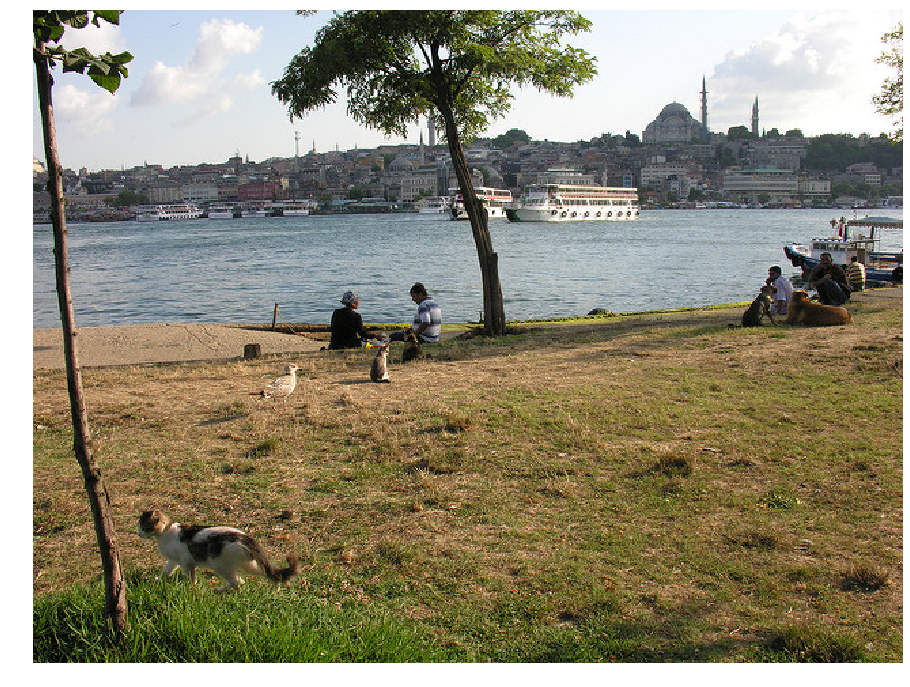

In [16]:
# from http://cocodataset.org/#explore?id=345434
image = load("http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg")
imshow(image)

### Computing the predictions

We provide a `run_on_opencv_image` function, which takes an image as it was loaded by OpenCV (in `BGR` format), and computes the predictions on them, returning an image with the predictions overlayed on the image.

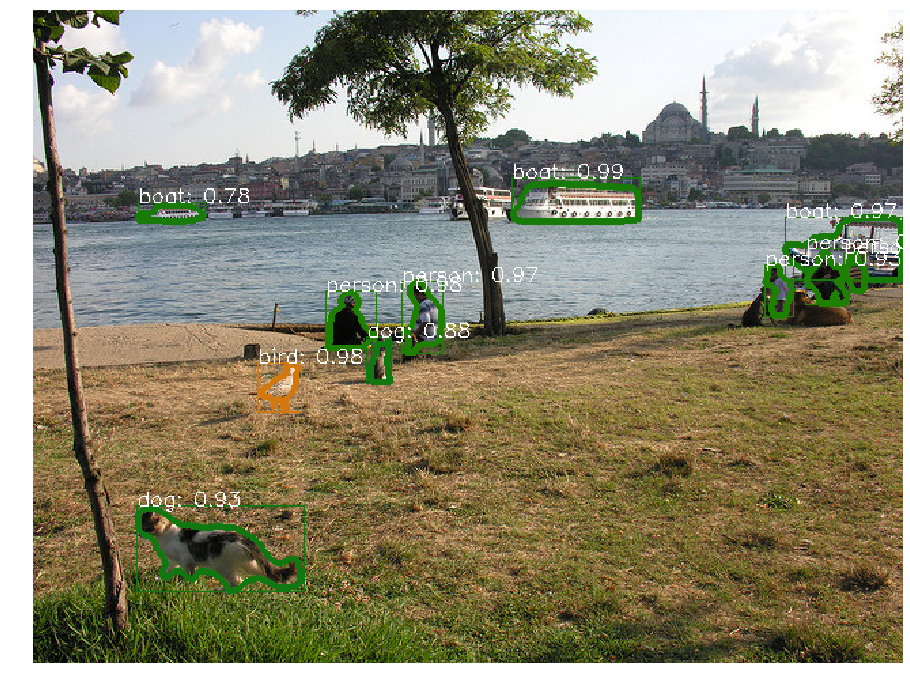

In [17]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)